# Application of the Matrix Completion Problem to Image Recovery

## Introduction

A wide range of datasets are naturally organized in matrix form. Some of the elements of these matrices can be unobserved, others can be lost. Thus, the problem of reconstruction missed values arises in many different contexts. For example, we can consider the term-document matrix: the frequencies of words used in a collection of documents can be represented as a matrix, where each entry corresponds to the number of times the associated term appears in the indicated document. Another important example is given by recommendation systems as occurred with the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) where users (rows of the data matrix) are given the opportunity to rate movies (columns of the data matrix) and the goal is to complete this matrix so that Netflix might recommend titles that any particular user is likely to be willing to order. There are many others cases where we need to fill matrices, thus there is high demand in robust and fast algorithms to solve this problem. Here we will consider image reconstruction, where some pixcels of a given image can be damaged or lost and the goal is to reconstruct it with high accuracy. We will develop from scratch the **Alternating Least Squares method (ALS)** as described in $[1]$. Other approaches can also be tryied, notably a **Riemmanian Optimization** as explained in $[2]$ or the **FastALS** algorithm, known as Rank-Restricted Efficient Maximum-Margin Matrix Factorization (SoftInput - ALS) as described in $[3]$. 

## The matrix completion problem
Imagine we have an $m\times n$ array of real numbers and that we are interested in knowing the value of each of the $mn$ entries in this array. Suppose, however, that we only get to see a small number of the entries so that most of the elements about which we wish information are simply missing. Is it possible from the available entries to guess the many entries that we have not seen? Clearly this problem is ill posed without making sutable assumptions on the data array (e.g. small rank). In particular if $n=m$ and the rank is $r$, the problem cannot be solved exactly with less then $2nr-r^2$ known values as can be observed using the Singular Value Decomposition (SVD) since, informally, the singular values in this decomposition depend on $r$ degrees of freedom and the singular vectors in the decomposition depend on  $(n − 1) + (n − 2) + . . . + (n − r) = nr − r(r + 1)/2$ degrees of freedom. In general if $m < 2nr − r$ no matter which entries are available, there can be an infinite number of matrices of rank at most r with exactly the same entries, and so exact matrix completion is impossible. Moreover if the observed locations are sampled at random, the minimum number of samples is better thought of as being on the order of $nr\log n$ rather than $nr$ because of a coupon collector’s effect. So, if we are interested in identifying large classes of matrices which can provably be recovered by a tractable algorithm from a number of samples approaching the above limit, i.e. from
about $nr\log n$ samples we can focus our attention on the subset $\Omega$ of this samples when $|\Omega|=nr\log n<nm$. 

If $X\in \mathbb{R}^{m\times n}$ denote a matrix that is only known on the set $\Omega$, let’s define the following projection operator $P_\Omega:\mathbb{R}^{m\times n}\to \mathbb{R}^{m\times n}$: if an entry $x_{ij}$ of $X$ is in $\Omega$ we keep that entry, otherwise we set $x_{ij}=0$. The information that $X$ is known only on $\Omega$ can be then encoded in the subspace $Y=P_\Omega(X)$ and we can consider the matrix completion problem as the following optimization problem: $$\textrm{minimize rank}(Z)\ \ s.t. P_\Omega(X) = P_\Omega(Z)$$ The last problem is NP-hard, but it has been proven to be well posed and solvable via convex programming techniques. In particular it has been shown that the solution of the previous problem can be found by studying its convex relaxation in terms of the nuclear norm (see $[5]$): $$\textrm{minimize}\ ||Z||_* \ \ s.t. P_\Omega(X) = P_\Omega(Z)$$

This convex relaxation is widely used and there are some strong theoretical probabilistic results in this topic. For instance, authors in $[5]$ showed that when $\Omega$ is sampled uniformly at random, then the nuclear relaxation of the problem can recover with high probability any matrix $X$ of rank $k$, provided that $m\geq C n^\frac{6}{5}
r \log n$.

Due to the presence of noise, we will consider a more robust version with the tolerance $\epsilon \geq 0$ such that $||P_\Omega(X)−P_\Omega(Z)||_F \leq ε$ (in Frobenious norm).

The **Alternating Least Squares method (ALS)** solves the matrix completion problem minimizing objective function $$ \textrm{minimize}\ ||P_\Omega(X −UV^T)||^2_F +\lambda(||U||^2_F +||V||^2_F)$$

where $U$ and $V$ are unknown matrices which we try to obtain. To avoid overfitting we use regularization term with coefficient $\lambda$. One can notice that this objective is non-convex, however, if we fix $U$ and treat it as constant matrix, then the objective is a convex function with respect to $V$, and vice versa. Consequently, if we fix one of the matrices and take derivatives with respect to columns of the second one and assign them to zero, then the roots of this equations will give global minimum of objective with fixed first matrix. After that we repeat these operations considering another matrix as constant, that is our approach will be to fix $U$ and optimize $V$, then fix $V$ and optimize $U$, and repeat until convergence. In this fashion we can obtain closed formulae for the iterative updates of $U$ and $V$: for $j=1,\dots, m$, $i=1,\dots, n$, and with $\Omega_j\subset \Omega$ the $j-$th column in the entry matrix $\Omega$, it holds
$$ U_j = \Bigl(\sum_{(j,h)\in \Omega_j} V_hV_h^T+\lambda\mathbf{1}_k \Bigr)^{-1}\cdot\Bigl(\sum_{(j,h)\in \Omega_j}X_{jh}V_h \Bigr)  $$
$$ V_i = \Bigl(\sum_{(h,i)\in \Omega^T_i} U_hU_h^T+\lambda\mathbf{1}_k \Bigr)^{-1}\cdot\Bigl(\sum_{(h,i)\in \Omega^T_i}X_{ih}U_h \Bigr)  $$
Summarizing: we can solve the matrix completion problem studying the nuclear norm convex relaxation problem iteratively, untill convergence, following the steps:
 1. Replace the missing entries in X with the corresponding entries from the current estimate $\hat{M}$: $\hat{X}\leftarrow P^\perp_Ω(\hat{X})$
 2. Calculate the SVD of $\hat(X)$: $\hat{X}=UDV^T$
 3. Update $\hat{M}$ with the (soft-thresholded) SVD in the previous step.
This same procedure can be adapted to solve Tensor Factorization Problems, as described in $[6]$. 

The **Fast Alternating Least Squares Method (Fast ALS)** is an optimization of the ALS algorithm (see $[2]$) try to reduce the high computational cost of step 2. in the ALS iterative method previously described. In $[7]$ two clever triks have been introduced to avoid such computational disadvantages:
 - Anticipating a low-rank solution, they compute a reduced-rank SVD in step 2; if the smallest of the computed singular values is less than $\lambda$, this gives the desired solution. A reduced-rank SVD can be computed by using an iterative Lanczos-style method as implemented $[8]$, or by other alternating-subspace methods.
 - They rewrite $\hat{X}$ as $\hat{X}=(P_\Omega(X)-P_\Omega(\hat{M}))+\hat{M}$.  The first piece is as sparse as $X$, and hence inexpensive to store and compute. The second piece is low rank, and also inexpensive to store. Furthermore, the iterative methods mentioned in step 1 require left and right multiplications of $\hat{X}$ by skinny matrices, which can exploit this special structure.
 
This *softImpute-ALS* algorithm works very well, and although an SVD needs to be computed each time step 2 is evaluated, this step can use the previous solution as a warm start. As one gets closer to the solution, the warm starts tend to be better, and so the final iterations tend to be faster. This approach has been extensively studied and the main algorithm can be found in $[7]$ Section 3, Algorithm 3.1.

## Set-up

In [7]:
import numpy as np
import scipy.sparse as sparse
from time import time

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import ALS
import ALS_with_nans
import FastALS

from PIL import Image
from tqdm import tqdm

In [8]:
def generate_random_problem(rows, cols, fill_coef, true_rank, random_state):
    
    """
    Generate random matrix completion problem
    
    Args:
        rows (int) number of rows
        cols (int) number of collomns
        fill_coef (float) [0, 1]: coefficient of observed values
        true_rank (int): True rank of matrix
        random_state (int): random state for repetition of the results
    
    
    Returns:
        X (np.array): Completed matrix of the problem
        Xw (csr_matrix): Matrix with missed values
    """
    
    np.random.seed(random_state)

    diag = np.random.uniform(0, 1, true_rank)
    diag = np.sort(diag)[::-1]
        
    S = np.diag(diag)
    U = np.random.uniform(0, 1, (rows, true_rank))
    V = np.random.uniform(0, 1, (cols, true_rank))
        
    Qu, Ru = np.linalg.qr(U)
    Qv, Rv = np.linalg.qr(V)
    
    X = Qu.dot(S).dot(Qv.T)
    
    num = int(X.size * fill_coef)

    np.random.seed(random_state)
    row_ind = np.random.randint(0, rows, size=num)
    col_ind = np.random.randint(0, cols, size=num)

    Xw = sparse.csr_matrix((X[(row_ind, col_ind)], (row_ind, col_ind)), shape=X.shape, dtype=np.float)
    
    return X, Xw

## ALS and FastALS performance with different problems

In [9]:
first = {'m': 300, 'n': 200, 'true_rank': 50, 'fill_coef': 0.2, 'approx_rank': 25, 'reg_coef': 0.3}
second = {'m': 300, 'n': 200, 'true_rank': 100, 'fill_coef': 0.2, 'approx_rank': 50, 'reg_coef': 0.3}
third = {'m': 1200, 'n': 900, 'true_rank': 100, 'fill_coef': 0.2, 'approx_rank': 50, 'reg_coef': 0.3}
forth = {'m': 2000, 'n': 1000, 'true_rank': 200, 'fill_coef': 0.2, 'approx_rank': 50, 'reg_coef': 0.3}
problems = [first, second, third, forth]

  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/tc/7dj2kw0x6gg0vc4x2qbfldv80000gn/T/ipykernel_48766/2104543987.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Xw = sparse.csr_matrix((X[(row_ind, col_ind)], (row_ind, col_ind)), shape=X.shape, dtype=np.float)
100%|█████████████████████████████████████████████| 4/4 [01:18<00:00, 19.69s/it]


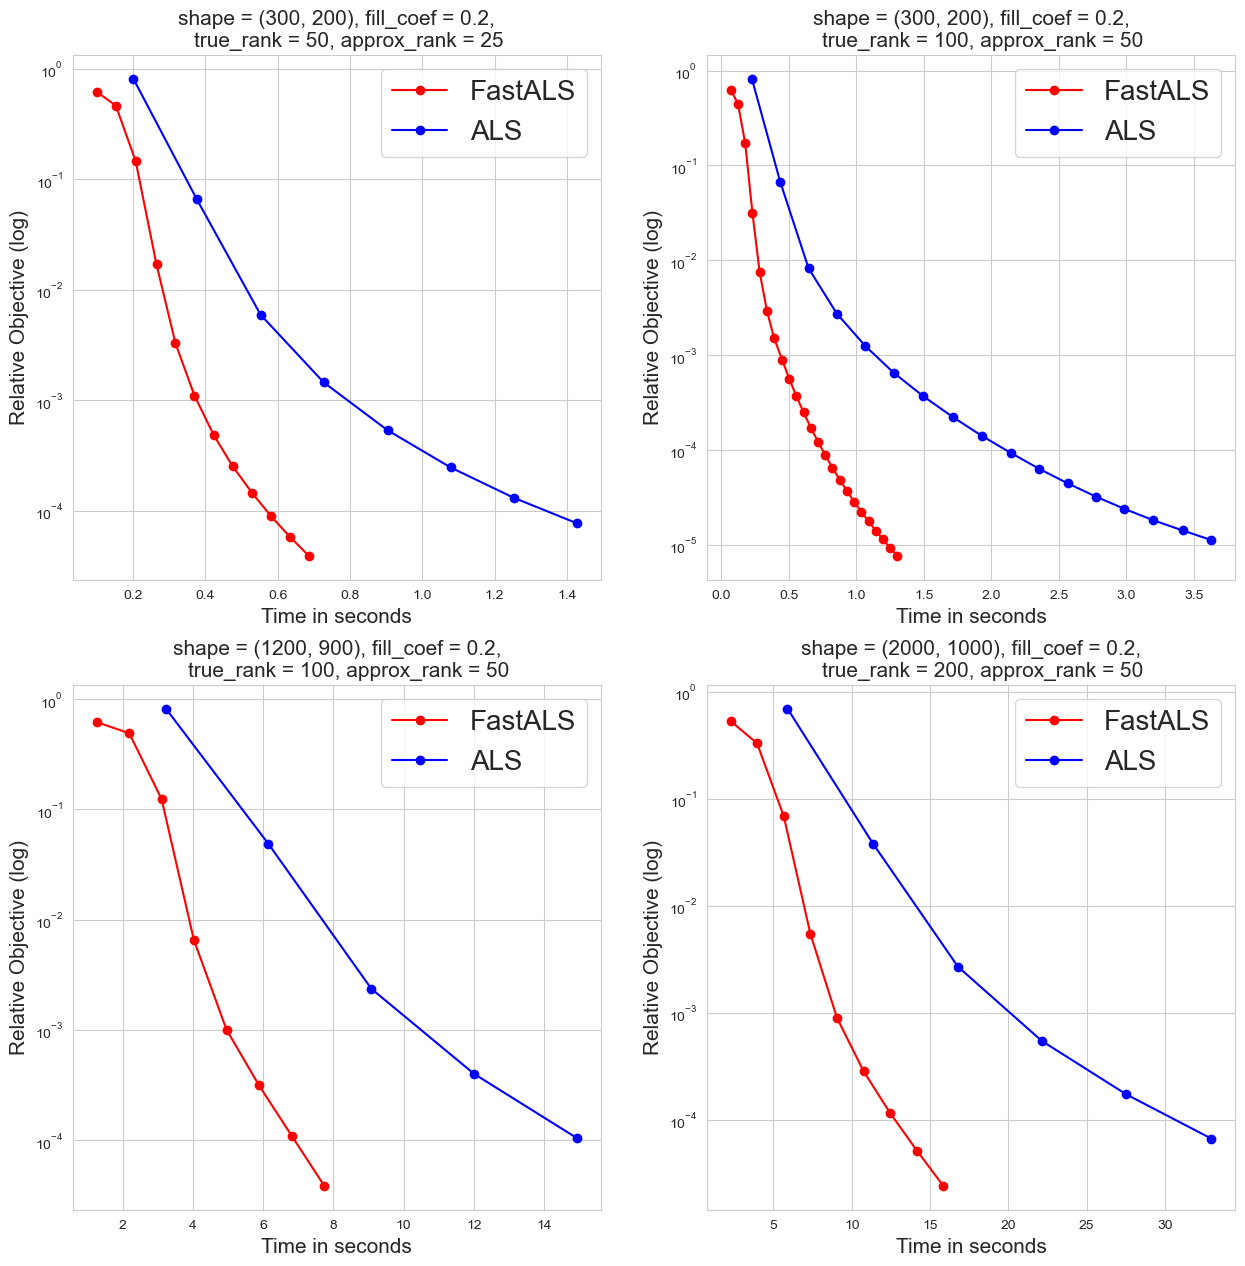

In [10]:
fig = plt.figure(figsize=(15, 15))

max_iter = 50
tol = 1e-5

start_time = time()

for it in tqdm(range(0, 4)):
    m = problems[it]['m']
    n = problems[it]['n']
    reg_coef = problems[it]['reg_coef']
    true_rank = problems[it]['true_rank']
    fill_coef = problems[it]['fill_coef']
    approx_rank = problems[it]['approx_rank']
    
    X, Xw = generate_random_problem(rows=m, cols=n, fill_coef=fill_coef, true_rank = true_rank, random_state=1)
    
    
    fast_als = FastALS.FastALS(rank=approx_rank, max_iter=max_iter, tol=tol, reg_coef=reg_coef)
    fast_als.fit(Xw, trace=True, debug_mode=False)
    
    als = ALS.ALS(rank=approx_rank, max_iter=max_iter, tol=tol, reg_coef=reg_coef)
    als.fit(Xw, trace=True, debug_mode = False)
    

    plot = fig.add_subplot(2, 2, it+1, yscale = 'log')
    
    plot.set_xlabel('Time in seconds', size = 15)
    plot.set_ylabel('Relative Objective (log)', size = 15)
    
    plot.plot(fast_als.get_time(), np.abs(fast_als.get_rel_obj()), '-o', c='r', label = 'FastALS')
    plot.plot(als.get_time(), np.abs(als.get_rel_obj()), '-o', c='b', label = 'ALS')
    
    plot.set_title("""shape = ({0}, {1}), fill_coef = {2},
    true_rank = {3}, approx_rank = {4}""".format(m, n, fill_coef, true_rank, approx_rank))
    plot.title.set_fontsize(15)
    plot.legend(loc = 'upper right', prop={'size': 20})
    
    
plt.show()

We see that with small datasets AlS' performances are still reasonably fast, but with huge datasets as those frequently used in real applications the execution time becomes too large. In this case the optimizations mentioned (fast ALS and Riemmanian Optimization) can be implemented with good results. Lukily for most image recovery problems ALS' performances are good enough.

## Application to image recovery

Here we will run the ALS algorithm to recover an image with 90% of missing pixels, with remarkable results. We had to adapt the previous ALS algorithm in order to manage the masked image with NaNs or to manage images whose lost pixels have been encoded as such.

In [5]:
def create_damaged_image_for_als(image, damage_ratio, plot_image=False):
    """
    
    This function creates matrix with missed values from given matrix of image.
    Returns initial image, image with NaNs after removing some values and damaged image, 
    where all NaNs are replaced with 0
    
    """
    np.random.seed(25)
    img = np.array(Image.open(image, mode='r'), dtype=np.uint8)
    
    damage = np.random.binomial(n=1, p=1-damage_ratio, size=img.shape)
    damaged_img = np.where(damage == 0, np.nan, img)
    damaged_without_nans = np.array(np.where(damage == 0, 0, img), dtype=np.uint8)

    if plot_image:
        plt.figure(figsize=(20, 10))
        plt.subplot(121)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Original image', fontsize=20)
        
        plt.subplot(122)
        plt.imshow(damaged_without_nans)
        plt.axis('off')
        plt.title('Damaged image', fontsize=20)

    return img, damaged_img, damaged_without_nans

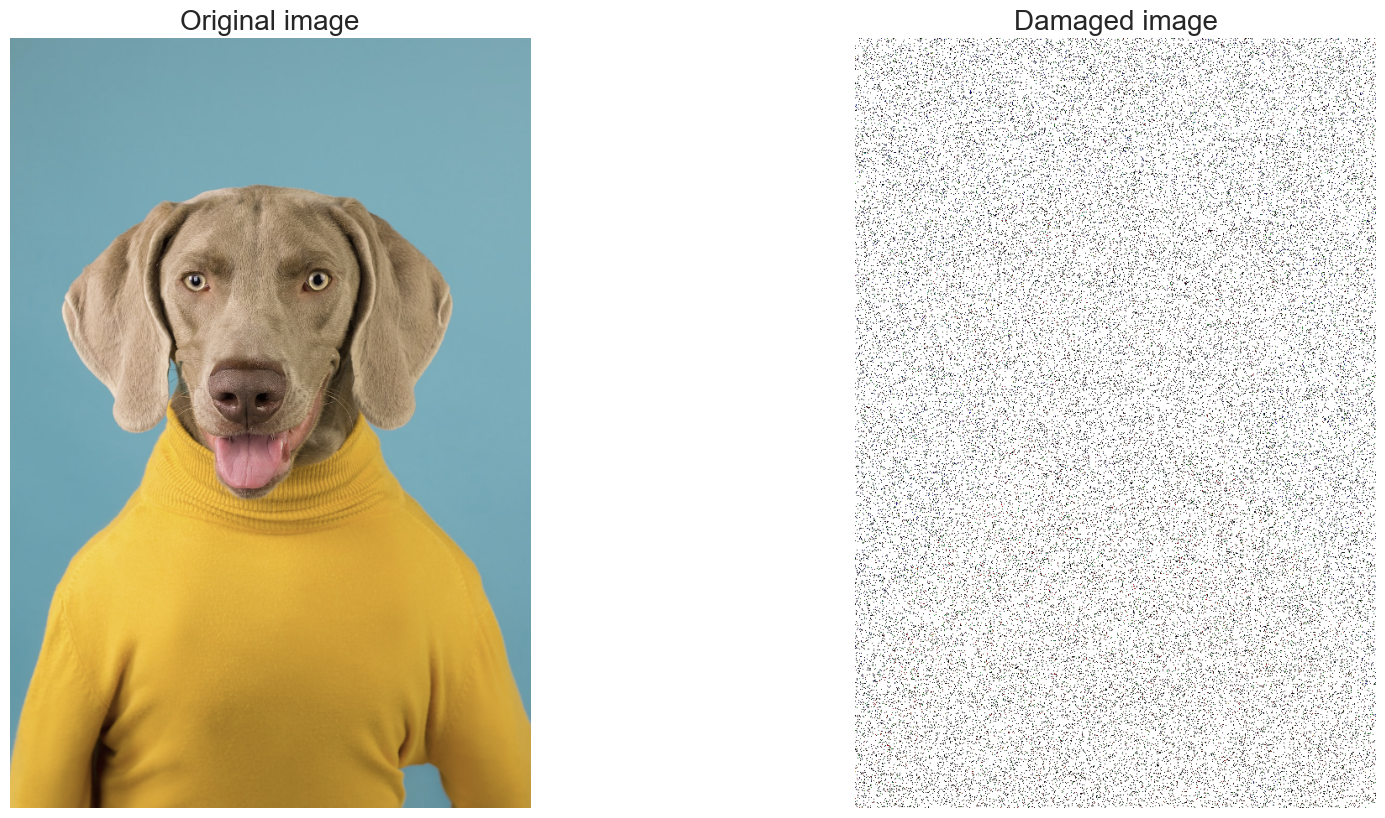

In [6]:
# 90% of damage

img, damaged_img, damaged_img_no_nans = create_damaged_image_for_als('foto.png', 0.9, True)

We create 3 different instances of ALS to predict each color channel of image, after that we fit them and predict missed values

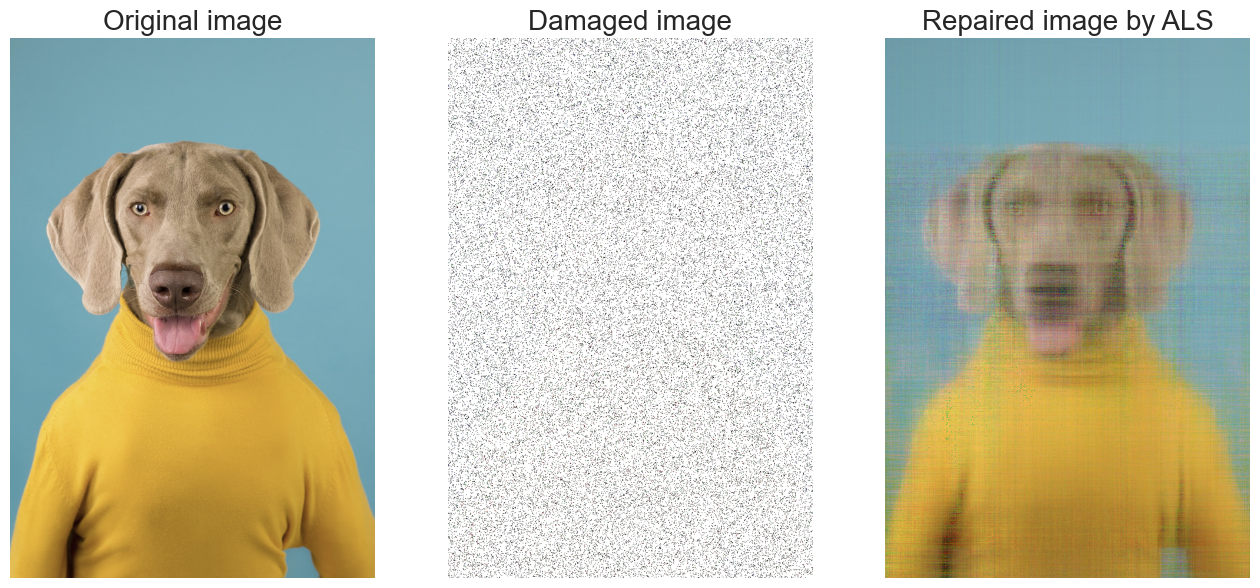

In [7]:
# This cell takes a while to run...

nanals_r = ALS_with_nans.ALS(max_iter=10, k=150, lambda_=1)
nanals_g = ALS_with_nans.ALS(max_iter=10, k=150, lambda_=1)
nanals_b = ALS_with_nans.ALS(max_iter=10, k=150, lambda_=1)

nanals_r.fit(sparse.csr_matrix(damaged_img[:,:,0]))
nanals_g.fit(sparse.csr_matrix(damaged_img[:,:,1]))
nanals_b.fit(sparse.csr_matrix(damaged_img[:,:,2]))

Ans_r_fa = np.array(nanals_r.predict(), dtype=np.uint8)
Ans_g_fa = np.array(nanals_g.predict(), dtype=np.uint8)
Ans_b_fa = np.array(nanals_b.predict(), dtype=np.uint8)

plt.figure(figsize=(16, 16))

plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.title('Original image', fontsize=20)

plt.subplot(132)
plt.imshow(damaged_img_no_nans)
plt.axis('off')
plt.title('Damaged image', fontsize=20)

plt.subplot(133)
plt.imshow(np.dstack((Ans_r_fa, Ans_g_fa, Ans_b_fa)))
plt.axis('off')
plt.title('Repaired image by ALS', fontsize=20)

plt.show()

## References

$[1]$ E.J. Candes, T. Tao, The Power of Convex Relaxation: Near-Optimal Matrix Completion https://arxiv.org/pdf/0903.1476.pdf

$[2]$ T. Hastie et al, Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares https://arxiv.org/pdf/1209.3834.pdf.

$[3]$ E.J Cande’s and T. Tao, The power of convex relaxation: Near-optimal matrix completion, IEEE Trans. Inform. Theory 56 (2009), 2053-2080 https://jmlr.org/papers/volume16/hastie15a/hastie15a.pdf

$[4]$ R. Zadeh, Lecture Notes on Distributed Algorithms and Optimization, Stanford (2015), available at https://stanford.edu/%7Erezab/classes/cme323/S15/notes/lec14.pdf.

$[5]$ E. J. Candes and B. Recht. Exact Matrix Completion via Convex Optimization. https://arxiv.org/abs/0805.4471

$[6]$ Sidiropoulos, N., et al. Tensor decomposition for signal processing and machine learning, IEEE Transactions on Signal Processing, vol. 65, n. 13, pp. 3551-3582, 2017. https://arxiv.org/pdf/1607.01668.pdf

$[7]$ Rahul Mazumder, Trevor Hastie, and Rob Tibshirani. Spectral regularization algorithms for
learning large incomplete matrices. Journal of Machine Learning Research, 11:2287–2322,
2010. https://www.jmlr.org/papers/volume11/mazumder10a/mazumder10a.pdf